Here I test the new version of processPatch.py, to use the appropriate error in faint points treatment. It used to be that the faint fluxes would be replaced by the faintMean,  but errors stayed the same. In fact we would like to replace errors with faintRMS.

Here I test how the S/N distribution looks like considering individual lightcurves, as well as the distribution of mean S/N per lightcurve considering all lightcurves in a given patch. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.table import Table
from astropy.table import Column
import os
import datetime
import pandas as pd 
import sys
path_to_home = '/Users/chris/GradResearch/'
sys.path.insert(0, path_to_home + 'SDSS_S82_FP_research/packages/')
import faintFunctions as faintF 
import variabilityFunctions as varF


## Read-in  raw lightcurves for one patch 

In [40]:
# args for Table.read are passed from  astropy.io.ascii.read
from astropy.io import ascii
ascii.read?

In [48]:
# USE ASTROPY !!!! 

DirIn = '../raw_data/rawDataFPSplit/'
fname = 'g00_21.csv.gz'
raw_data = Table.read(DirIn+fname, format='csv', include_names =['objectId', 'mjd', 
                                                                 'psfFlux', 'psfFluxErr'])
# http://docs.astropy.org/en/stable/io/ascii/read.html 
# gives parameters to reading tables 
# data_end still reads the entire table 
# and only returns a small portion.... 

# need to use pd.read_csv,  select nrows, and then convert to AstroPy : 
# will be much faster : 

In [46]:
# http://docs.astropy.org/en/stable/io/ascii/read.html 
# gives parameters to reading tables 
# data_end still reads the entire table 
# and only returns a small portion.... 

#raw_data = Table.read(DirIn+fname, format='csv', include_names =['objectId', 'mjd', 
#                               'psfFlux', 'psfFluxErr'], data_end=1000)

# better to use pd.read_csv,  select nrows, and then convert to AstroPy : 
# will be much faster : 
limitNrows = None 
if limitNrows is not None:  
    raw_data_df = pd.read_csv(DirIn+fname, compression='gzip',  
                         usecols=['objectId', 'mjd', 'psfFlux', 'psfFluxErr'], 
                              nrows=limitNrows )
    raw_data = Table.from_pandas(raw_data_df)

In [573]:
raw_data_df = pd.read_csv(DirIn+fname, compression='gzip',  
                         usecols=['objectId', 'mjd', 'psfFlux', 'psfFluxErr'], 
                              nrows=None )

In [49]:
##########  STEP 1 : single-epoch data ###########  
# 1.1  :  convert Flux from erg/cm2/sec/Hz  to Jansky
#         1 Jy = 1.0E-26 W/m^2/Hz = 1.0E-23 erg/s/cm^2/Hz
# make new columns with data in Jy, to follow good 
# programming practice (otherwise, changes are either
# on a view or a copy and it's not always clear)

raw_data['psfFluxJy'] = raw_data['psfFlux'] * 1E23 
raw_data['psfFluxErrJy'] = raw_data['psfFluxErr'] * 1E23 



In [47]:
len(raw_data)


1000

In [566]:
# 1.2  : drop all rows which have NaNs in psfFlux .... 
m1  = np.isnan(raw_data['psfFlux'].data)  # true if NaN 
m2 = np.bitwise_not(np.isfinite(raw_data['psfFlux'].data))  # true if not finite... 

# logical or : true if either condition satisfied 
m = m1 | m2  

if np.sum(m) > 0 :  # only apply if there is anything to drop ... 
    print('In  file %s there are : \n.... %d NaN  psfFlux rows'%(fname, np.sum(m1)))
    print('.... %d not finite  psfFlux rows'% np.sum(m2))
    print('All such rows are dropped')
    indices = np.arange(len(test))
    rows_to_remove = indices[mask]
    raw_data.remove_rows(remove_indices)

# 1.3 : check psfFluxErr : drop all rows which have NaN, or 0 ,
# to avoid getting error when calculating S/N  = psfFlux / psfFluxErr 

m1  = np.isnan(raw_data['psfFluxErr'].data)  # true if NaN 
m2 =  np.bitwise_not(np.isfinite(raw_data['psfFluxErr'].data))  # true if not finite... 
m3 = raw_data['psfFluxErr'].data == 0 
# logical or : true if either condition satisfied 
m = m1 | m2  | m3

if np.sum(m) > 0 :  # only apply if there is anything to drop ... 
    print('In  file %s there are : \n.... %d NaN  psfFluxErr rows'%(fname, np.sum(m1)))
    print('.... %d not finite  psfFluxErr rows'% np.sum(m2))
    print('.... %d psfFluxErr = 0  rows'% np.sum(m3))
    print('All such rows are dropped')

# 1.4 : select points that have S/N  < 2 , flag as Faint...
# initialize a new column with all values set to False :
#flagFaint = Column(data = np.zeros(len(raw_data), dtype=bool), name = 'flagFaint')
# this would also work, but doesn't allow to select good data type 
# raw_data['flagFaint'] = True : makes a new col with int64

# instead of two-steps, make just one : 
mask_SN = (raw_data['psfFluxJy'].data / raw_data['psfFluxErrJy'].data) < 2 
raw_data['flagFaint'] = mask_SN
print('There are %d points of %d that have S/N < 2' %(np.sum(mask_SN),len(mask_SN)))





There are 19138954 points of 39238241 that have S/N < 2


AttributeError: 'Column' object has no attribute 'values'

In [8]:
print('hello')

hello


### Aside : Plot the SN demographics using raw photometry 

In [9]:
import matplotlib.pyplot as plt
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 20

We will save this figure in  /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_SN_raw_data/2017-05-09/
Saved as SN_demographics.png


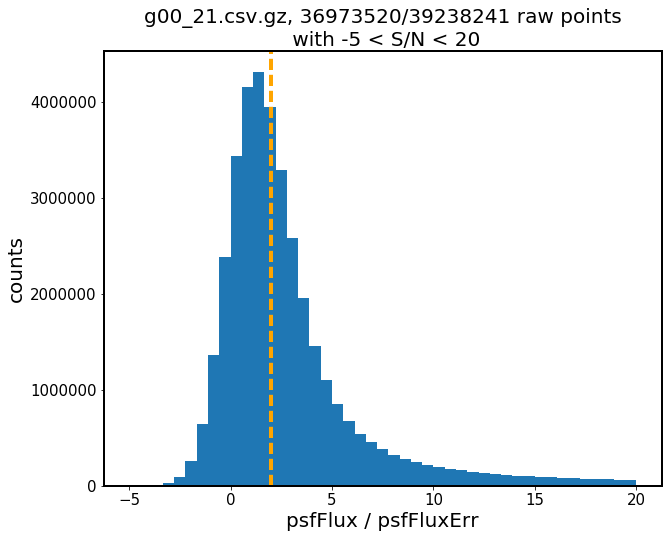

In [111]:
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_SN_raw_data',
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('We will save this figure in  %s'%outDir)


%matplotlib inline
min_SN, max_SN = -5, 20 
m = (min_SN < SN) *  ( SN < max_SN)

fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.hist(SN[m], bins=45)
ax.set_xlabel('psfFlux / psfFluxErr')
ax.set_ylabel('counts')
ax.set_title(fname+', '+ str(len(SN[m]))+'/'+str(len(SN))+\
             ' raw points\n with '+ str(min_SN)+' < S/N < '+str(max_SN))

ax.axvline(2, ls = '--', color='orange', lw=4)

figname = 'SN_demographics.png'
plt.savefig(outDir + '/' +figname)
print('Saved as %s'%figname)


In [421]:
SN = raw_data['psfFluxJy'].data / raw_data['psfFluxErrJy'].data


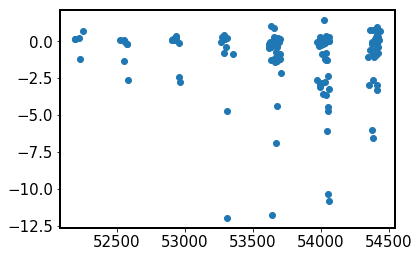

In [434]:
m = raw_data['objectId'].data == 216278347443865913
plt.scatter(raw_data['mjd'][m], 1e5*raw_data['psfFluxJy'][m]) # , raw_data.psfFluxErrJy[m] )

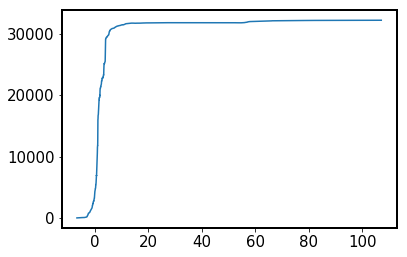

In [452]:
#plt.hist(SN[:1000])
cs = np.cumsum(SN[:10000])
plt.plot(np.sort(SN[:10000]), cs)

In [449]:
len(SN[SN<2])

19138954

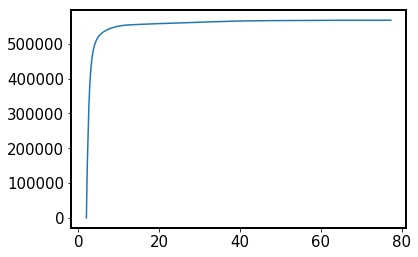

### Back to analysis : faint points treatment ... 

In [88]:
imp.reload(faintF)

<module 'faintFunctions' from '/Users/chris/GradResearch/SDSS_S82_FP_research/packages/faintFunctions.py'>

In [133]:
# 1.5  calculate faint quantities for all rows  where S/N < 2 
imp.reload(faintF)
# make new columns ...
for faintColname in ['faintMean', 'faintMedian','faintTwoSigma','faintRMS']:
    raw_data[faintColname] = np.nan
    # initialize for all rows, 
    # and we will have not nans 
    # only wherever it is possible 
    # to calculate faintMean, faintMedian 
    # faintRMS, etc., iff    -20 < S/N < 2  
      
# only perform faint point treatment for 
# points where S/N > -20 (xObs = S/N) 
# Above that we are getting into a very very small
# portion of the tail, and 
# norm.sf(-xObs) ~= 0 for such small S/N values
# which makes is impossible to properly 
# calculate faintMean, and faintRMS,
# both of which require normalization
# I1 = norm.sf(-xObs)


SN = raw_data['psfFluxJy'].data / raw_data['psfFluxErrJy'].data
mask_faint  =  (-20 < SN ) * (SN < 2 )

# temporary assignment
flux, flux_err = raw_data['psfFluxJy'][mask_faint].data, raw_data['psfFluxErrJy'][mask_faint].data
 
raw_data['faintMean'][mask_faint]= faintF.calculate_mean(flux, flux_err)
raw_data['faintMedian'][mask_faint] = faintF.calculate_median(flux, flux_err)
raw_data['faintTwoSigma'][mask_faint] = faintF.calculate_2sigma(flux, flux_err)
raw_data['faintRMS'][mask_faint] = faintF.calculate_rms(flux, flux_err)


In [138]:

SN[mask_faint][np.where(raw_data['faintRMS'][mask_faint] - flux_err == 0)]

array([-8.71830185, -8.64923767, -7.96757668, -8.65326188, -8.30368047,
       -8.67095746, -8.37058319, -8.40811155, -8.04410601, -8.20910086,
       -8.72142039, -8.08406944, -8.30257383, -8.26571932, -8.42518685,
       -8.75606264, -8.63899669, -8.18358915, -8.38975596, -7.8026182 ,
       -7.99452456, -8.36598739, -8.31077729, -8.16184057, -8.11794548,
       -8.34277117, -8.5130329 , -8.4623343 , -8.59520115, -8.49755989,
       -8.22610433, -8.66617302, -8.533499  , -8.65673878, -8.49234924,
       -8.11813448, -8.42791908, -8.30114976, -8.33568709, -7.8832635 ,
       -7.90318421, -8.51468651, -8.39058153, -8.34698805, -8.78970087,
       -8.07389191, -7.99648277, -8.74130879, -8.6556417 , -8.21405544,
       -8.49355548, -8.10218657, -8.04460575, -8.52839709, -8.51368594,
       -7.93120619, -8.17271933, -8.11052469, -8.41770083, -8.0740914 ,
       -8.78020783, -8.03217954, -8.42762337, -7.94325395, -7.91653747,
       -7.77691407, -7.98350287, -8.18188524, -7.95113388, -8.38

In [125]:
from scipy.special import erf

xObs = psfFlux / psfFluxErr
xMean = faintF.calculate_mean(psfFlux, psfFluxErr) / psfFluxErr
delX = xObs - xMean
I1 = norm.sf(-xObs)
I0bysig2 = 0.5*erf(xObs/np.sqrt(2)) + (1.0/np.sqrt(2*np.pi))*np.exp(-(xObs**2.0) / 2.0)*(2*delX - xObs) + 0.5 + delX*delX*norm.sf(-xObs)

### xMean 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: overflow encountered in true_divide


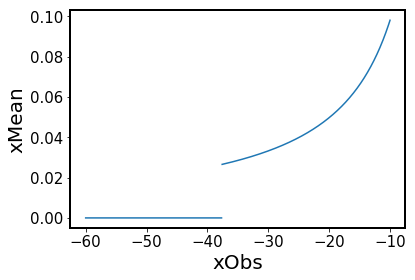

In [467]:
# Figure out if there are any problems with the implementation of the xMean ... 

xObs = np.linspace(-60,-10, 1000)
sf = norm.sf(-xObs )
I_norm  = sf 

# since the norm is in the divisor, if we can't divide by it,  it would be 
# far better to say 
xMean = np.zeros_like(xObs)
ind = np.where(sf !=0 )
# only divide by sf where the divisor is nonzero ... 
xMean[ind] = (1/ (sf[ind]*np.sqrt(2*np.pi))) *\
             np.exp(-(xObs[ind]**2.0) / 2.0) + xObs[ind]

plt.plot(xObs, xMean)
plt.plot(xObs[xObs>0], xObs[xObs>0], ls='--')
#plt.plot(np.linspace(-30,-20,100), np.zeros(100))
plt.xlabel('xObs')
plt.ylabel('xMean')

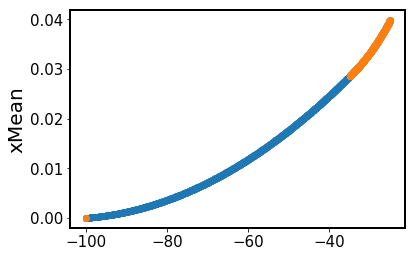

In [476]:
# Fit a spline to a region between -35 and -25 
from scipy.interpolate import spline

mask = (-35<xObs)*(xObs<-25)
x = xObs[mask]
y = xMean[mask]

x = np.append(x,-100)
y = np.append(y,0)

x_new = np.linspace(min(x), max(x), 1000)
y_new = spline(np.sort(x), np.sort(y), x_new, order=2)

#x_new = np.append(x_new, np.linspace(-120,-100,100))
#y_new = np.append(y_new, np.zeros(100))

plt.plot(x_new,y_new, 'o',  x, y, 'o')
plt.ylabel('xMean')




/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: overflow encountered in true_divide


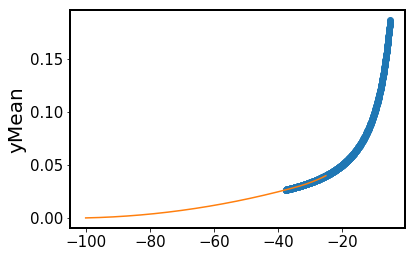

In [480]:
# Patch all together...
xObs = np.linspace(-60,-5, 1000)
sf = norm.sf(-xObs )
I_norm  = sf 

xMean = np.zeros_like(xObs)
ind = np.where(sf !=0 )
# only divide by sf where the divisor is nonzero ... 
xMean[ind] = (1/ (sf[ind]*np.sqrt(2*np.pi))) *\
             np.exp(-(xObs[ind]**2.0) / 2.0) + xObs[ind]

plt.plot(xObs[ind], xMean[ind], 'o', x_new, y_new)
plt.ylabel('yMean')


In [522]:
# Mean  : pull all together ....
from scipy.interpolate import spline

# evaluate xMean analytically where I know sf is nonzero....
xObs = np.arange(-35,3,0.01)
sf = norm.sf(-xObs )
xMean = (1/ (sf*np.sqrt(2*np.pi))) *\
             np.exp(-(xObs**2.0) / 2.0) + xObs
    
# region of analytic expression to which we fit a spline 
mask = (-35<xObs)*(xObs<-25)
x = xObs[mask]
y = xMean[mask]

# add a fitting 'peg' at (x,y) = (-100, 0)
x = np.append(x,-100)
y = np.append(y,0)

# here x goes from -100 to -25 
x_new = np.arange(min(x), max(x), step=0.01)
y_new = spline(np.sort(x), np.sort(y), x_new, order=2)

# combine the old and the new : 
xObs = np.append(xObs, x_new[x_new<-35])
xMean = np.append(xMean, y_new[x_new<-35])

xObs = np.sort(xObs)
xMean = np.sort(xMean)

# make sure that it is indeed as equally spaced (has the same length)
# as if we just made it from scratch 
assert len(np.arange(-100,3,0.01)) == len(xObs)

# initialize the lookup table here  : 
# in each next element need to ensure that
# indeed we will have the same number of elements 
# as xObs,  i.e. 10300  
lookup_table = {'xObs':xObs, 'xMean':xMean}

In [525]:
lookup_table

{'xMean': array([ -3.63797881e-12,   6.50408360e-07,   1.30197070e-06, ...,
          2.97485426e+00,   2.98471175e+00,   2.99457297e+00]),
 'xObs': array([-100.  ,  -99.99,  -99.98, ...,    2.97,    2.98,    2.99])}

### xMedian

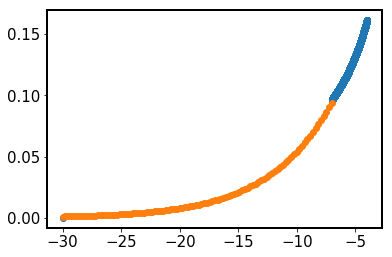

In [238]:
# xMedian 

# fit a sigmoid  to the region between -7 and -3 
from scipy.optimize import curve_fit
mask = (-7<xObs)*(xObs<-4)
x = xObs[mask]
y = xMed[mask]

x = np.append(x,-30)
y = np.append(y,0)

# calculate polynomial
z = np.polyfit(x, y, 4)
f = np.poly1d(z)

def sigmoid(x, x0, k):
     y = 1 / (1 + np.exp(-k*(x-x0)))
     return y
popt, pcov = curve_fit(sigmoid, x,y)

x_new = np.linspace(x[0], x[-1], 100)
y_new = sigmoid(x_new, *popt) 

plt.plot(x,y,'o', x_new, y_new, 'o')

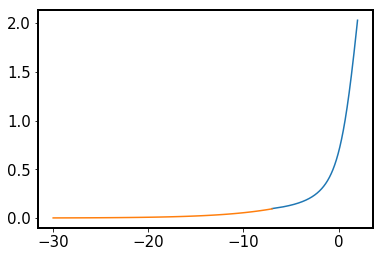

In [244]:
# plot patching the analytical calculation and the 
# functional fit below 
xObs = np.linspace(-7,2, 1000)
xMed = np.zeros_like(xObs)
indices = norm.cdf(-xObs) < 1 
xMed[indices] = norm.ppf((1+norm.cdf(-xObs[indices]))/2.0) + xObs[indices]
plt.plot(xObs,xMed)
plt.plot(x_new, y_new)

In [526]:
# xMedian : combine all ... 

# 1) initialize 
xpeg, xmin,xmid, xmax = -30,-7,-4,3
step = 0.01
x0 = -100 
xObs = np.arange(xmin, xmax, step)
xMed= norm.ppf((1+norm.cdf(-xObs))/2.0) + xObs


# 2) fit a sigmoid  to the region between -7 and -3 
from scipy.optimize import curve_fit
mask = (xmin<xObs)*(xObs<xmid)
x = xObs[mask]
y = xMed[mask]

x = np.append(x,xpeg)
y = np.append(y,0)

def sigmoid(x, x0, k):
     y = 1 / (1 + np.exp(-k*(x-x0)))
     return y
popt, pcov = curve_fit(sigmoid, x,y)

x_new = np.arange(x0, max(x), step)
y_new = sigmoid(x_new, *popt) 

# combine the old and the new : 
mask  = x_new<xmin
xObs = np.append(xObs, x_new[mask])
xMed= np.append(xMed, y_new[mask])

# 4) sort , since function monotonically increasing ... 
xObs = np.sort(xObs)
xMed = np.sort(xMed)

# 5) make sure that it is indeed as equally spaced (has the same length)
# as if we just made it from scratch 
assert len(np.arange(x0,xmax, step)) == len(xObs)
lookup_table['xMedian'] = xMed


### xRMS

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in sqrt


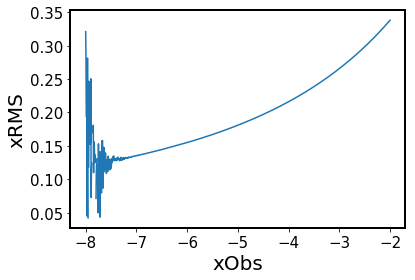

In [580]:
# x RMS  ... 

xObs = np.linspace(-8,-2, 1000)
sf = norm.sf(-xObs )
I_norm  = sf 

# since the norm is in the divisor, if we can't divide by it,  it would be 
# far better to say 
xMean = np.zeros_like(xObs)
ind = np.where(sf !=0 )
# only divide by sf where the divisor is nonzero ... 
xMean[ind] = (1/ (sf[ind]*np.sqrt(2*np.pi))) *\
             np.exp(-(xObs[ind]**2.0) / 2.0) + xObs[ind]


delX  = xObs - xMean

numerator = 0.5*erf(xObs/np.sqrt(2)) +\
           (1.0/np.sqrt(2*np.pi))*np.exp(-(xObs**2.0) / 2.0)*(2*delX - xObs) +\
           0.5 + delX*delX*norm.sf(-xObs)

index = I_norm >0 
xRMS = np.sqrt(numerator[index] / I_norm[index])

%matplotlib inline
plt.plot(xObs[index], xRMS )

plt.xlabel('xObs')
plt.ylabel('xRMS')

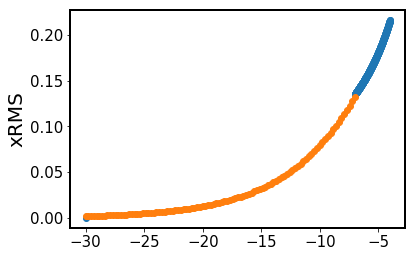

In [581]:
# fit a sigmoid function ... to xObs between  -3 and -7  :

from scipy.optimize import curve_fit
mask = (-7<xObs)*(xObs<-4)
x = xObs[mask]
y = xRMS[mask]
# add a pegging at 0 
x = np.append(x,-30)
y = np.append(y,0)

# function to fit 
def sigmoid(x, x0, k):
     y = 1 / (1 + np.exp(-k*(x-x0)))
     return y
popt, pcov = curve_fit(sigmoid, x,y)

x_new = np.linspace(x[0], x[-1], 100)
y_new = sigmoid(x_new, *popt) 

plt.plot(x,y,'o', x_new, y_new, 'o')
plt.ylabel('xRMS')



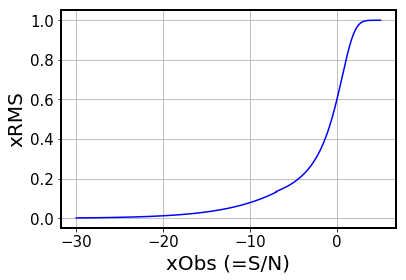

In [591]:
# plot patching the analytical calculation and the 
# functional fit below 
xObs = np.linspace(-7,5, 1000)
xRMS = np.zeros_like(xObs)

sf = norm.sf(-xObs )
I_norm  = sf 

# since the norm is in the divisor, if we can't divide by it,  it would be 
# far better to say 
xMean = np.zeros_like(xObs)
ind = np.where(sf !=0 )
# only divide by sf where the divisor is nonzero ... 
xMean[ind] = (1/ (sf[ind]*np.sqrt(2*np.pi))) *\
             np.exp(-(xObs[ind]**2.0) / 2.0) + xObs[ind]


delX  = xObs - xMean

numerator = 0.5*erf(xObs/np.sqrt(2)) +\
           (1.0/np.sqrt(2*np.pi))*np.exp(-(xObs**2.0) / 2.0)*(2*delX - xObs) +\
           0.5 + delX*delX*norm.sf(-xObs)

index = I_norm >0 
xRMS[index] = np.sqrt(numerator[index] / I_norm[index])


plt.plot(xObs,xRMS, c='b')
plt.plot(x_new, y_new, c='b')
plt.ylabel('xRMS')
plt.xlabel('xObs (=S/N)')
plt.grid()
plt.savefig(outDir + 'xRMS_total_range.png', bbox_inches='tight')

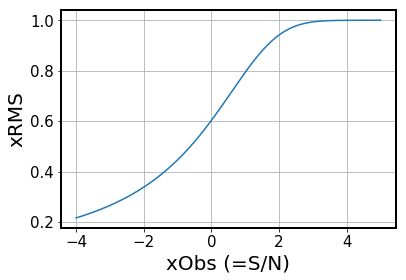

In [592]:
m = xObs>-4
plt.plot(xObs[m],xRMS[m])
#plt.plot(x_new, y_new)
plt.ylabel('xRMS')
plt.xlabel('xObs (=S/N)')
plt.grid()
plt.savefig(outDir + 'xRMS_detail.png', bbox_inches='tight')

In [586]:
outDir

'/Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_faint_integration/2017-05-11/'

In [527]:
# xRMS : pull all together 
# to make a lookup table 

# 1) initialize 
xpeg, xmin,xmid, xmax = -30,-7,-4,3
step = 0.01
x0 = -100 
xObs = np.arange(xmin, xmax, step)

sf = norm.sf(-xObs )
xMean = (1/ (sf*np.sqrt(2*np.pi))) *\
             np.exp(-(xObs**2.0) / 2.0) + xObs
    
    
delX  = xObs - xMean

numerator = 0.5*erf(xObs/np.sqrt(2)) +\
           (1.0/np.sqrt(2*np.pi))*np.exp(-(xObs**2.0) / 2.0)*(2*delX - xObs) +\
           0.5 + delX*delX*norm.sf(-xObs)   


# I know that in this range sf is ~= 0  
# so we don't need any further constraints ...
xRMS = np.sqrt(numerator /sf)

    

# 2) fit a sigmoid  to the region between -7 and -3 
from scipy.optimize import curve_fit
mask = (xmin<xObs)*(xObs<xmid)
x = xObs[mask]
y = xRMS[mask]

x = np.append(x,xpeg)
y = np.append(y,0)

def sigmoid(x, x0, k):
     y = 1 / (1 + np.exp(-k*(x-x0)))
     return y
popt, pcov = curve_fit(sigmoid, x,y)
x_new = np.arange(x0, max(x), step)
y_new = sigmoid(x_new, *popt) 

# 3) combine the old and the new : 
mask  = x_new<xmin
xObs = np.append(xObs, x_new[mask])
xRMS= np.append(xRMS, y_new[mask])

# 4) sort , since function monotonically increasing ... 
xObs = np.sort(xObs)
xRMS = np.sort(xRMS)

# 5) make sure that it is indeed as equally spaced (has the same length)
# as if we just made it from scratch 
assert len(np.arange(x0,xmax, step)) == len(xObs)
lookup_table['xRMS'] = xRMS

### x 2sigma 

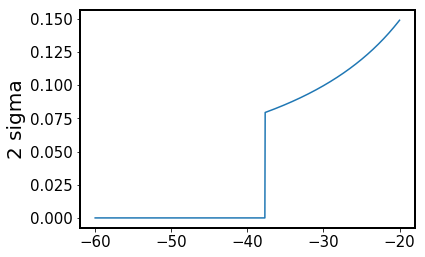

In [336]:
# Does 2-sigma calculation suffer from anything due to floating point precision  ?

xObs = np.linspace(-60,-20, 1000)
indices = norm.sf(-xObs) > 0 
xSigma = np.zeros_like(xObs)

xSigma[indices] = xObs[indices] + norm.isf(0.05 * norm.sf(-xObs[indices]))
plt.plot(xObs,xSigma)
plt.ylabel('2 sigma')


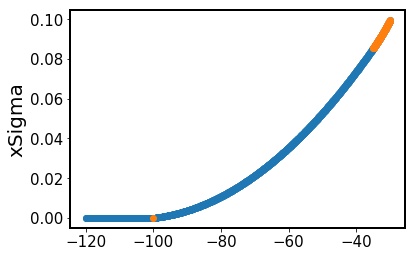

In [413]:
# fit a spline ... 

from scipy.interpolate import spline
mask = (-35<xObs)*(xObs<-30)
x = xObs[mask]
y = xSigma[mask]
x = np.append(x,-100)
y = np.append(y,0)

x_new = np.linspace(min(x), max(x), 1000)
y_new = spline(np.sort(x), np.sort(y), x_new, order=2)

x_new = np.append(x_new, np.linspace(-120,-100,100))
y_new = np.append(y_new, np.zeros(100))

plt.plot(x_new,y_new, 'o',  x, y, 'o')
plt.ylabel('xSigma')

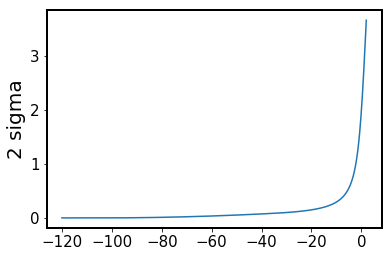

In [417]:
# add the patched part to the analytical part ....

xObs = np.linspace(-35,2, 1000)
xSigma = np.zeros_like(xObs)
xSigma = xObs + norm.isf(0.05 * norm.sf(-xObs))

xObs   = np.append(xObs, x_new)
xSigma = np.append(xSigma, y_new)
plt.plot(np.sort(xObs),np.sort(xSigma))
plt.ylabel('2 sigma')

In [528]:
# x 2sigma  : pull all together 
from scipy.optimize import curve_fit

# 1) initialize 
xpeg, xmin,xmid, xmax = -100,-35,-30,3
step = 0.01
x0 = -100 
xObs = np.arange(xmin, xmax, step)
xSigma = xObs + norm.isf(0.05 * norm.sf(-xObs))    
    
# 2) fit a spline  
mask = (xmin<xObs)*(xObs<xmid)
x = xObs[mask]
y = xSigma[mask]

x = np.append(x,xpeg)
y = np.append(y,0)

x_new = np.arange(x0, xmid, step)
y_new = spline(np.sort(x), np.sort(y), x_new, order=2)

# 3) combine the old and the new : 
mask  = x_new<xmin
xObs = np.append(xObs, x_new[mask])
xSigma= np.append(xSigma, y_new[mask])

# 4) sort , since function monotonically increasing ... 
xObs = np.sort(xObs)
xSigma = np.sort(xSigma)

# 5) make sure that it is indeed as equally spaced (has the same length)
# as if we just made it from scratch 
assert len(np.arange(x0,xmax, step)) == len(xObs)
lookup_table['xSigma'] = xSigma

In [529]:
lookup_table

{'xMean': array([ -3.63797881e-12,   6.50408360e-07,   1.30197070e-06, ...,
          2.97485426e+00,   2.98471175e+00,   2.99457297e+00]),
 'xMedian': array([  1.12581059e-09,   1.12803273e-09,   1.13025925e-09, ...,
          2.97186618e+00,   2.98180633e+00,   2.99174823e+00]),
 'xObs': array([-100.  ,  -99.99,  -99.98, ...,    2.97,    2.98,    2.99]),
 'xRMS': array([  3.15214923e-09,   3.15815198e-09,   3.16416617e-09, ...,
          9.92753384e-01,   9.92943498e-01,   9.93129353e-01]),
 'xSigma': array([  0.00000000e+00,   1.96753502e-06,   3.93850865e-06, ...,
          4.61557592e+00,   4.62555274e+00,   4.63553024e+00])}

### Make lookup table for xObs,  xMean, xMedian, xRMS, x2sigma

In [547]:
# Combine all parts of making the lookup table into one thing that 
# can be easily rerun if needed ... 

from scipy.interpolate import spline

###############################
# Mean  : pull all together ....
###############################

# 1) initialize 
xpeg, xmin,xmid, xmax = -100,-35,-25,3
step = 0.01
x0 = -100 

xObs = np.arange(xmin,xmax,0.01)
sf = norm.sf(-xObs )
# evaluate xMean analytically where I know sf is nonzero....
xMean = (1/ (sf*np.sqrt(2*np.pi))) *\
             np.exp(-(xObs**2.0) / 2.0) + xObs
    
# region of analytic expression to which we fit a spline 
mask = (xmin<xObs)*(xObs<xmid)
x = xObs[mask]
y = xMean[mask]

# add a fitting 'peg' at (x,y) = (-100, 0)
x = np.append(x,xpeg)
y = np.append(y,0)

# here x goes from -100 to -25 
x_new = np.arange(min(x), max(x),step)
y_new = spline(np.sort(x), np.sort(y), x_new, order=2)

# combine the old and the new : 
xObs = np.append(xObs, x_new[x_new<xmin])
xMean = np.append(xMean, y_new[x_new<xmin])

xObs = np.sort(xObs)
xMean = np.sort(xMean)

# make sure that it is indeed as equally spaced (has the same length)
# as if we just made it from scratch 
assert len(np.arange(x0,xmax,step)) == len(xObs)

# initialize the lookup table here  : 
# in each next element need to ensure that
# indeed we will have the same number of elements 
# as xObs,  i.e. 10300  
lookup_table = {'xObs':xObs, 'xMean':xMean}

###############################
# xMedian : combine all ... 
###############################

# 1) initialize 
xpeg, xmin,xmid, xmax = -30,-7,-4,3
step = 0.01
x0 = -100 
xObs = np.arange(xmin, xmax, step)
xMed= norm.ppf((1+norm.cdf(-xObs))/2.0) + xObs


# 2) fit a sigmoid  to the region between -7 and -3 
from scipy.optimize import curve_fit
mask = (xmin<xObs)*(xObs<xmid)
x = xObs[mask]
y = xMed[mask]

x = np.append(x,xpeg)
y = np.append(y,0)

def sigmoid(x, x0, k):
     y = 1 / (1 + np.exp(-k*(x-x0)))
     return y
popt, pcov = curve_fit(sigmoid, x,y)

x_new = np.arange(x0, max(x), step)
y_new = sigmoid(x_new, *popt) 

# combine the old and the new : 
mask  = x_new<xmin
xObs = np.append(xObs, x_new[mask])
xMed= np.append(xMed, y_new[mask])

# 4) sort , since function monotonically increasing ... 
xObs = np.sort(xObs)
xMed = np.sort(xMed)

# 5) make sure that it is indeed as equally spaced (has the same length)
# as if we just made it from scratch 
assert len(np.arange(x0,xmax, step)) == len(xObs)
lookup_table['xMedian'] = xMed


###############################
# xRMS : pull all together 
###############################

# 1) initialize 
xpeg, xmin,xmid, xmax = -30,-7,-4,3
step = 0.01
x0 = -100 
xObs = np.arange(xmin, xmax, step)

sf = norm.sf(-xObs )
xMean = (1/ (sf*np.sqrt(2*np.pi))) *\
             np.exp(-(xObs**2.0) / 2.0) + xObs
      
delX  = xObs - xMean

numerator = 0.5*erf(xObs/np.sqrt(2)) +\
           (1.0/np.sqrt(2*np.pi))*np.exp(-(xObs**2.0) / 2.0)*(2*delX - xObs) +\
           0.5 + delX*delX*norm.sf(-xObs)   

# I know that in this range sf is != 0  
# so we don't need any further constraints ...
xRMS = np.sqrt(numerator /sf)

# 2) fit a sigmoid  to the region between -7 and -3 
from scipy.optimize import curve_fit
mask = (xmin<xObs)*(xObs<xmid)
x = xObs[mask]
y = xRMS[mask]

x = np.append(x,xpeg)
y = np.append(y,0)

def sigmoid(x, x0, k):
     y = 1 / (1 + np.exp(-k*(x-x0)))
     return y
popt, pcov = curve_fit(sigmoid, x,y)
x_new = np.arange(x0, max(x), step)
y_new = sigmoid(x_new, *popt) 

# 3) combine the old and the new : 
mask  = x_new<xmin
xObs = np.append(xObs, x_new[mask])
xRMS= np.append(xRMS, y_new[mask])

# 4) sort , since function monotonically increasing ... 
xObs = np.sort(xObs)
xRMS = np.sort(xRMS)

# 5) make sure that it is indeed as equally spaced (has the same length)
# as if we just made it from scratch 
assert len(np.arange(x0,xmax, step)) == len(xObs)
lookup_table['xRMS'] = xRMS


###############################
# x 2sigma  : pull all together 
################################
from scipy.optimize import curve_fit

# 1) initialize 
xpeg, xmin,xmid, xmax = -100,-35,-30,3
step = 0.01
x0 = -100 
xObs = np.arange(xmin, xmax, step)
xSigma = xObs + norm.isf(0.05 * norm.sf(-xObs))    
    
# 2) fit a spline  
mask = (xmin<xObs)*(xObs<xmid)
x = xObs[mask]
y = xSigma[mask]

x = np.append(x,xpeg)
y = np.append(y,0)

x_new = np.arange(x0, xmid, step)
y_new = spline(np.sort(x), np.sort(y), x_new, order=2)

# 3) combine the old and the new : 
mask  = x_new<xmin
xObs = np.append(xObs, x_new[mask])
xSigma= np.append(xSigma, y_new[mask])

# 4) sort , since function monotonically increasing ... 
xObs = np.sort(xObs)
xSigma = np.sort(xSigma)

# 5) make sure that it is indeed as equally spaced (has the same length)
# as if we just made it from scratch 
assert len(np.arange(x0,xmax, step)) == len(xObs)
lookup_table['xSigma'] = xSigma


################################################
# convert to AstroPy table to display and save ... 
################################################

lookup = Table(lookup_table)
table_address = '../packages/flat_prior_const_couns_lookup.csv'
lookup.write(table_address)


### Check that interpolation works  on a subset of g00_21 raw FP data 

In [550]:
# given S/N,  i.e. xObs,   which is the 
# flux scaled by error, we are able to 
# return values of xMean, xMedian , xRMS, x2sigma 
faint_SN = SN[SN<2]

lookup = Table.read(table_address)

# takes just a few seconds to run on an entire filter- patch !
# I think we are fine, I hit the sweetspot 
xMean =  np.interp(faint_SN, lookup['xObs'].data, lookup['xMean'].data)
xMed =  np.interp(faint_SN, lookup['xObs'].data, lookup['xMedian'].data)
xSigma =  np.interp(faint_SN, lookup['xObs'].data, lookup['xSigma'].data)
xRMS = np.interp(faint_SN, lookup['xObs'].data, lookup['xRMS'].data)



In [549]:
raw_data.colnames

['objectId',
 'mjd',
 'psfFlux',
 'psfFluxErr',
 'psfFluxJy',
 'psfFluxErrJy',
 'flagFaint',
 'faintMean',
 'faintMedian',
 'faintTwoSigma',
 'faintRMS']

In [552]:
# Integrate this into 
# LC_processing.py 
mask_faint = SN < 2 
flux = raw_data['psfFluxJy'][mask_faint].data
flux_err = raw_data['psfFluxErrJy'][mask_faint].data
 
raw_data['faintMean'][mask_faint]     = xMean * flux_err
raw_data['faintMedian'][mask_faint]   = xMed * flux_err
raw_data['faintTwoSigma'][mask_faint] = xSigma * flux_err
raw_data['faintRMS'][mask_faint]      = xRMS * flux_err

In [558]:
2 in range(0,11)

True

### Aside : Illustrate the flat prior with Gaussian flux likelihood 

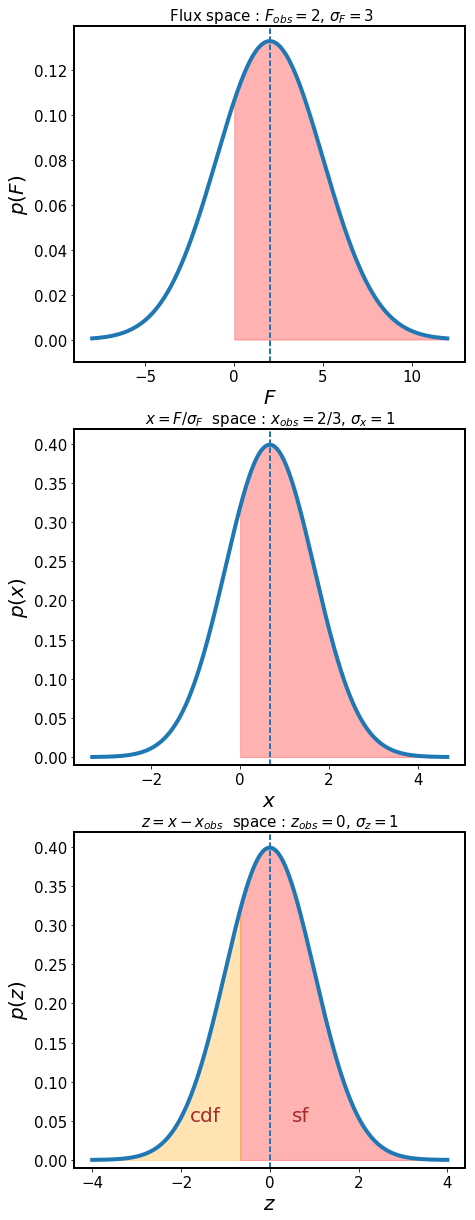

In [288]:
# depict the three distributions .. .

from scipy.stats import norm

fig,(ax1,ax2,ax3) = plt.subplots(3,1, figsize=(7,21))

# F - space
F_obs = 2
sigF = 3
width  = 10 
F = np.arange(F_obs-width,F_obs+width, 0.001)
ax1.plot(F,norm.pdf(F,F_obs, sigF), lw=4 , label='p(F)')
ax1.axvline(F_obs, ls='--', lw=2)
ax1.set_ylim(-.01)
ax1.set_ylabel(r'$p(F)$', fontsize=20)
ax1.set_xlabel(r'$F$', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=15) 
ax1.set_title(' Flux space : '+r'$F_{obs} = 2$'+', '+r'$\sigma_{F}=3$', fontsize=15)
# shade the positive part 
mask = F>0
ax1.fill_between(F[mask],norm.pdf(F[mask],F_obs, sigF), alpha=0.3, color='red' )


# x-space 

F_obs = 2
sigF = 3
x_obs = F_obs / sigF
width  = 4
x = np.arange(x_obs-width,x_obs+width, 0.001)
ax2.plot(x,norm.pdf(x,x_obs, 1), lw=4 , label='p(x)')
ax2.axvline(x_obs, ls='--', lw=2)
ax2.set_ylim(-.01)
ax2.set_ylabel(r'$p(x)$', fontsize=20)
ax2.set_xlabel(r'$x$', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=15) 
ax2.set_title(r'$ x = F /\sigma_{F}$'+'  space : '+r'$x_{obs} = 2/3$'+\
             ', '+r'$\sigma_{x}=1$', fontsize=15)
# shade the positive part 
mask = x>0
ax2.fill_between(x[mask],norm.pdf(x[mask],x_obs, 1), alpha=0.3, color='red' )

# z-space 

F_obs = 2
sigF = 3
x_obs = F_obs / sigF
width  = 4
x = np.arange(x_obs-width,x_obs+width, 0.001)
z = x - x_obs
ax3.plot(z,norm.pdf(z,0, 1), lw=4 , label='p(x)')
ax3.axvline(0, ls='--', lw=2)
ax3.set_ylim(-.01)
ax3.set_ylabel(r'$p(z)$', fontsize=20)
ax3.set_xlabel(r'$z$', fontsize=20)
ax3.tick_params(axis='both', which='major', labelsize=15) 
ax3.set_title(r'$ z = x - x_{obs}$'+'  space : '+r'$z_{obs} = 0$'+\
             ', '+r'$\sigma_{z}=1$', fontsize=15)
# shade the xobs part....  : sf 
mask = z>-x_obs
ax3.fill_between(z[mask],norm.pdf(z[mask],0, 1), alpha=0.3, color='red' )
ax3.text(0.5, 0.05, 'sf', fontsize=20, color='brown')

# shade the xobs part....  : cdf
mask = z<-x_obs
ax3.fill_between(z[mask],norm.pdf(z[mask],0, 1), alpha=0.3, color='orange' )
ax3.text(-1.8, 0.05, 'cdf', fontsize=20, color='brown')

outDir ='/Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_faint_integration/2017-05-11/'
plt.savefig(outDir + 'faintPipeline_F_x_z_spaces.pdf', bbox_inches='tight')

### Plot rawError  / faintRMS ...

In [553]:
outDir

'/Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_faint_integration/2017-05-11/'

Saved as FluxErr_RMS_ratio_NEW.png


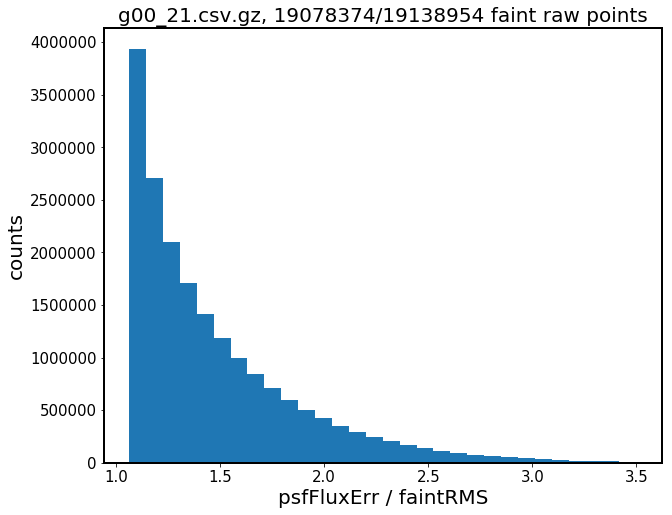

In [554]:
# remove nan rows ... 
flux_err, rms =  raw_data['psfFluxErrJy'][mask_SN].data, raw_data['faintRMS'][mask_SN].data

m1 = np.bitwise_not(np.isnan(rms))
m2 =  (0.99 < flux_err / rms  )*( flux_err / rms < 3.5)
m = m1 * m2 


fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.hist(flux_err[m] / rms[m], bins=30)
ax.set_xlabel('psfFluxErr / faintRMS')
ax.set_ylabel('counts')
ax.set_title(fname+', '+ str(len(rms[m]))+'/'+str(len(rms))+\
             ' faint raw points')

figname = 'FluxErr_RMS_ratio_NEW.png'
plt.savefig(outDir + '/' +figname, bbox_inches = 'tight')
print('Saved as %s'%figname)




Conclude: the new error is smaller from the original error up to even 3 times ! 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log10


Saved as FluxErr_RMS_ratio_vs_SN_NEW.png


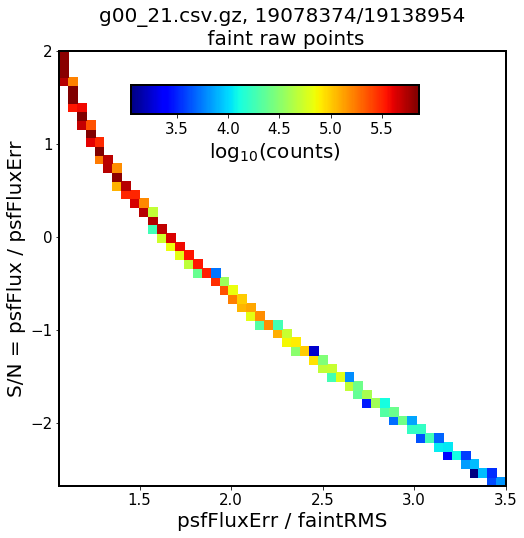

In [555]:
# Plot also     S/N    vs  psfFluxErr / faintRMS : color by counts ....
from matplotlib import ticker
from scipy.stats import binned_statistic_2d

flux_err, rms =  raw_data['psfFluxErrJy'][mask_SN].data, raw_data['faintRMS'][mask_SN].data
SN = raw_data['psfFluxJy'][mask_SN].data / raw_data['psfFluxErrJy'][mask_SN].data 

m1 = np.bitwise_not(np.isnan(rms))
m2 =  (0.99 < (flux_err / rms)  )*( (flux_err / rms) < 3.5)
m3 = SN > -5
m = m1 * m2 *m3

x = flux_err[m] / rms[m]
y = SN[m]

fig,ax = plt.subplots(1,1,figsize=(8,8))
stats = binned_statistic_2d(x=x, y=y, values=x, statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

# Plot 2D histogram using pcolor
image = ax.pcolormesh(x_edges,y_edges, np.log10(z_masked), cmap='jet')
cax =   fig.add_axes([0.25, 0.77, 0.5, 0.05]) 
colorbar = fig.colorbar(image,  cax=cax, orientation='horizontal')
colorbar.set_label(r'$\log_{10}(\mathrm{counts})$', fontsize=20)

ax.set_xlabel('psfFluxErr / faintRMS')
ax.set_ylabel('S/N = psfFlux / psfFluxErr')

ax.set_title(fname+', '+ str(len(rms[m]))+'/'+str(len(rms))+\
             '\n faint raw points')
figname = 'FluxErr_RMS_ratio_vs_SN_NEW.png'
plt.savefig(outDir + '/' +figname, bbox_inches = 'tight')
print('Saved as %s'%figname)




In [12]:
# 1.6  replace psfFluxJy  by  faintMean ,

# make sure we are only taking values  that are not NaN ... 
mask_NaNs = np.bitwise_not(np.isnan(raw_data['faintRMS'][mask_SN]))

# psfFluxErrJy  by  faintRMS 
raw_data['psfFluxJy'][mask_SN][mask_NaNs] = raw_data['faintMean'][mask_SN][mask_NaNs]
raw_data['psfFluxErrJy'][mask_SN][mask_NaNs] = raw_data['faintRMS'][mask_SN][mask_NaNs]


In [13]:
#
##########  STEP 2 : Derived Quantities ###########  
#
# Here the main choice is whether we want to introduce 
# selection of which points to use per lightcurve based 
# on S/N before grouping, or after grouping . 
#

# At the moment, it is impossible to apply complicated 
# functions to groupby objects....
# Easier at this point to just convert AstroPy table 
# to Pandas,  and do it from here on in Pandas ...
# Bummer. 

# But thankfully it only takes a few seconds 
# even on mac,  on the full patch  file 
raw_data_df = raw_data[:100].to_pandas()



66.44499950000001

In [21]:
oid = np.unique(raw_data['objectId'].data)

In [31]:
# isolate data for only one object with LC length of 71, 
# to test the speed of execution of computeVarMetrics
# on one object only .
mask_oid = raw_data['objectId'].data == oid[0]
raw_data_df = raw_data[mask_oid].to_pandas()

In [33]:
%timeit varMetricsFull_bright  = bright_grouped.apply(varF.computeVarMetrics, flux_column='psfFluxJy',  error_column = 'psfFluxErrJy',time_column = 'mjd', verbose=False, calc_sigma_pdf = True)

# with calc_sigma_pdf = True : 10 loops, best of 3: 25.2 ms per loop  
# with calc_sigma_pdf = False : 100 loops, best of 3: 8.01 ms per loop

10 loops, best of 3: 24.9 ms per loop


In [569]:
raw_data_df = raw_data.to_pandas()

In [576]:
cols_save= ['objectId', 'meanSN', 'mjd']
raw_data_subset = raw_data_df.loc[:100, cols_save]  

In [578]:
#/raw_data_subset

In [570]:
import imp
imp.reload(varF)
# 2.2 Calculate stats for LC using only bright points 
mask_bright = ~raw_data_df['flagFaint'].values
bright_grouped = raw_data_df[mask_bright].groupby('objectId')
varMetricsFull_bright  = bright_grouped.apply(varF.computeVarMetrics, 
                                              flux_column='psfFluxJy',
                                              error_column = 'psfFluxErrJy',
                                              time_column = 'mjd')

# 2.3 Calculate stats for LC using all points 
all_grouped = raw_data_df.groupby('objectId')
varMetricsFull_all  = all_grouped.apply(varF.computeVarMetrics, 
                                              flux_column='psfFluxJy',
                                              error_column = 'psfFluxErrJy',
                                              time_column = 'mjd') 



objectId= 216172782516437336
objectId= 216172782516437336
objectId= 216172782516437339
objectId= 216172782516437345
objectId= 216172782516437346
objectId= 216172782516437358
objectId= 216172782516437360
objectId= 216172782516437362
objectId= 216172782516437371
objectId= 216172782516437379
objectId= 216172782516437381
objectId= 216172782516437383
objectId= 216172782516437384
objectId= 216172782516437388
objectId= 216172782516437394
objectId= 216172782516437396
objectId= 216172782516437400
objectId= 216172782516437405
objectId= 216172782516437407
objectId= 216172782516437414
objectId= 216172782516437415
objectId= 216172782516437420
objectId= 216172782516437427
objectId= 216172782516437437
objectId= 216172782516437440
objectId= 216172782516437442
objectId= 216172782516437443
objectId= 216172782516437448
objectId= 216172782516437449
objectId= 216172782516437451
objectId= 216172782516437453
objectId= 216172782516437458
objectId= 216172782516437465
objectId= 216172782516437476
objectId= 2161

KeyboardInterrupt: 

In [571]:
mask_bright

array([ True,  True,  True, ..., False, False, False], dtype=bool)

The two are very different!  Now we want to prepend some string to each column, so that I know which chi2 was calculated using all points, and which using only bright points.Then we want to stack them  : at this point, it's easier to convert all back to AstroPy and use hstack  http://docs.astropy.org/en/stable/api/astropy.table.hstack.html

In [317]:
# 2.4  calculate magnitudes from fluxes ... 
def flux2absigma(flux, fluxsigma):
      """Compute AB mag sigma given flux and flux sigma

      Here units of flux,  fluxsigma  don't matter 
      as long as they are consistent, since we are dividing 
      one by the other, so all the units cancel out.
      """
      FIVE_OVER_2LOG10 = 1.085736204758129569
      return FIVE_OVER_2LOG10 * fluxsigma / flux;


def flux2ab(flux, unit = 'Jy'):
  """Compute AB mag given flux. 

  Accept two unit types :  
  *  'cgs', meaning flux is in  ergs / s / Hz / cm2
  *  'Jy', meaning flux is in Jy.  1 Jy = 1E-23 * ergs/s/Hz/cm2
  """
  if unit == 'Jy':
    return -2.5 * np.log10(flux) + 8.90
  elif unit == 'cgs':
    return -2.5 * np.log10(flux) - 48.6

# Calculate magnitudes based on average fluxes :
# psfMean  psfMedian  psfMeanErr  psfMedianErr 
varMetricsFull_all['psfMean'] = flux2ab(varMetricsFull_all['psfFluxMean'], unit='Jy')
varMetricsFull_all['psfMedian'] = flux2ab(varMetricsFull_all['psfFluxMedian'], unit='Jy')
varMetricsFull_all['psfMeanErr'] = flux2absigma(varMetricsFull_all['psfFluxMean'],
                                                varMetricsFull_all['psfFluxMeanErr'])
varMetricsFull_all['psfMedianErr'] = flux2absigma(varMetricsFull_all['psfFluxMedian'],
                                                  varMetricsFull_all['psfFluxMedianErr'])


varMetricsFull_bright['psfMean'] = flux2ab(varMetricsFull_bright['psfFluxMean'], unit='Jy')
varMetricsFull_bright['psfMedian'] = flux2ab(varMetricsFull_bright['psfFluxMedian'], unit='Jy')
varMetricsFull_bright['psfMeanErr'] = flux2absigma(varMetricsFull_bright['psfFluxMean'],
                                                varMetricsFull_bright['psfFluxMeanErr'])
varMetricsFull_bright['psfMedianErr'] = flux2absigma(varMetricsFull_bright['psfFluxMedian'],
                                                  varMetricsFull_bright['psfFluxMedianErr'])

print('Calculating magnitudes from fluxes is finished')


# 2.5  change colnames to reflect which subset of points per lightcurve was used 
# the easiest way to do it is to add_suffix in pandas 

varMetricsFull_all = varMetricsFull_all.add_suffix('_all')
varMetricsFull_bright = varMetricsFull_bright.add_suffix('_bright')

# 2.6 combine the two ... 
varMetricsFull_combined = pd.concat([varMetricsFull_all,varMetricsFull_bright], axis=1)


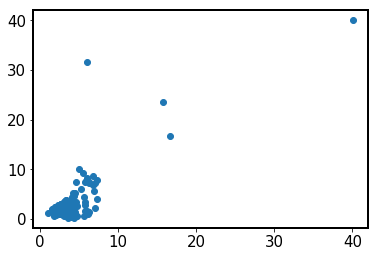

In [323]:
# Now we can easily plot quantities calculated using all points 
# or only bright points,
# as well as select 'bright' objects , which have high meanSN_all,  
# or those that are 'dim' - have a low meanSN_all...  

#plt.hist(varMetricsFull_combined['N_all'])
#plt.hist(varMetricsFull_combined['N_bright'])

plt.scatter(varMetricsFull_combined.chi2DOF_all, varMetricsFull_combined.chi2DOF_bright)

In [325]:
# How many cols we have now per band?

len(varMetricsFull_combined.columns)

56

In [ ]:
# this means over 250 cols in combined file !  
# starts getting overwhelming... 

